<a href="https://colab.research.google.com/github/FarimaM/Machine-Learning-Course/blob/main/Homework6_Session6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project Assignment: DEAP Dataset Arousal Classification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/DEAP_Dataset'
print("Dataset path set to:", data_path)

Dataset path set to: /content/drive/MyDrive/DEAP_Dataset


Classify arousal into two classes:
- **Low Arousal** (class 0): arousal rating ≤ 5
- **High Arousal** (class 1): arousal rating > 5

In [6]:
## Load the DEAP dataset (preprocessed EEG data and labels)
import numpy as np
import os

# Create empty lists to store EEG data, all labels, and arousal ratings
eeg_data_all = []
labels_all = []
arousal_labels = []

# Loop through all 10 subject files
for subject_id in range(1, 11):
    file_name = os.path.join(data_path, f's{subject_id:02d}.dat')
    with open(file_name, 'rb') as file:
        subject = np.load(file, allow_pickle=True, encoding='latin1')
        trials = subject['data']
        labels = subject['labels']

        for trial_index in range(40):
            eeg_trial = trials[trial_index]           # EEG data for one trial
            label_vector = labels[trial_index]        # [valence, arousal, dominance, liking]
            arousal = label_vector[1]                 # Arousal rating (1 to 9)

            eeg_data_all.append(eeg_trial)
            labels_all.append(label_vector)
            arousal_labels.append(arousal)

# Convert lists to NumPy arrays
eeg_data_all = np.array(eeg_data_all)
labels_all = np.array(labels_all)
arousal_labels = np.array(arousal_labels)

# Print basic info
print("Loaded EEG data shape:", eeg_data_all.shape)
print("Loaded full label matrix shape:", labels_all.shape)
print("Loaded arousal label vector shape:", arousal_labels.shape)

Loaded EEG data shape: (400, 40, 8064)
Loaded full label matrix shape: (400, 4)
Loaded arousal label vector shape: (400,)


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Extract band power features
from scipy.signal import welch

def compute_bandpower_features(trial, fs=128):
    bands = [(1, 4), (4, 8), (8, 13), (13, 30), (30, 45)]
    features = []
    for channel in trial:
        f, Pxx = welch(channel, fs=fs)
        for low, high in bands:
            idx = (f >= low) & (f <= high)
            features.append(np.sum(Pxx[idx]))
    return features

X = np.array([compute_bandpower_features(trial) for trial in eeg_data_all])

## Classify arousal into two classes:
#- **Low Arousal** (class 0): arousal rating ≤ 5
#- **High Arousal** (class 1): arousal rating > 5

y = np.array([0 if r <= 5 else 1 for r in arousal_labels])  # Binary labels

print(" Feature matrix shape:", X.shape)
print(" Label distribution:", np.bincount(y))

 Feature matrix shape: (400, 200)
 Label distribution: [198 202]


1. **Compare resampling techniques**
   - Implement at least THREE different resampling methods:
    * Random oversampling
     * Random undersampling
     * SMOTE

   - Use proper cross-validation (stratified K-fold) to evaluate each method
   - Compare results using precision, recall, F1-score
   - CRITICAL: Apply resampling ONLY to training folds, never to test data!

In [8]:
## Compare Resampling Techniques
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

resamplers = {
    'Oversampling': RandomOverSampler(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_model = LogisticRegression(max_iter=1000)

results = {}

for name, sampler in resamplers.items():
    print(f"\n Resampling Method: {name}")
    precision_scores, recall_scores, f1_scores = [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Resample only training data
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

        # Train and evaluate
        model = clone(base_model)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)

        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    print(f"Precision: {np.mean(precision_scores):.3f}")
    print(f"Recall:    {np.mean(recall_scores):.3f}")
    print(f"F1 Score:  {np.mean(f1_scores):.3f}")

    results[name] = {
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores)
    }


 Resampling Method: Oversampling


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Precision: 0.594
Recall:    0.569
F1 Score:  0.579

 Resampling Method: Undersampling


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Precision: 0.594
Recall:    0.535
F1 Score:  0.561

 Resampling Method: SMOTE


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Precision: 0.582
Recall:    0.544
F1 Score:  0.560


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

2. **Test algorithm-level approaches**
   - Implement class weighting for at least TWO different algorithms
   - Compare performance with and without class weights
   - Analyze the trade-off between precision and recall

In [9]:
## Test Algorithm-Level Class Weighting
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    'SVM (no weight)': SVC(class_weight=None),
    'SVM (weighted)': SVC(class_weight='balanced'),
    'RF (no weight)': RandomForestClassifier(class_weight=None),
    'RF (weighted)': RandomForestClassifier(class_weight='balanced')
}

print("\n Class Weighting Comparison\n")

for name, model in models.items():
    precision_scores, recall_scores, f1_scores = [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)

        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    print(f" {name}")
    print(f"Precision: {np.mean(precision_scores):.3f}")
    print(f"Recall:    {np.mean(recall_scores):.3f}")
    print(f"F1 Score:  {np.mean(f1_scores):.3f}")
    print("-" * 40)


 Class Weighting Comparison

 SVM (no weight)
Precision: 0.563
Recall:    0.569
F1 Score:  0.565
----------------------------------------
 SVM (weighted)
Precision: 0.557
Recall:    0.544
F1 Score:  0.550
----------------------------------------
 RF (no weight)
Precision: 0.545
Recall:    0.589
F1 Score:  0.565
----------------------------------------
 RF (weighted)
Precision: 0.541
Recall:    0.605
F1 Score:  0.568
----------------------------------------


## Bonus Challenges (Optional)

1. **Multi-class classification**: Divide arousal into 3 or more levels
2. **Feature engineering**: Extract additional EEG features beyond band powers or use dimension reduction methods
3. **Ensemble methods**: Combine multiple models for improved performance
4. **Temporal analysis**: Investigate how arousal changes over time within trials
5. **Subject-specific models**: Compare subject-independent vs subject-specific approaches

In [10]:
## 1. Multi-Class Classification: Arousal into 3 Levels
# Convert arousal ratings (1–9) into 3 classes
def bin_arousal_3class(rating):
    if rating <= 3:
        return 0  # Low
    elif rating <= 6:
        return 1  # Medium
    else:
        return 2  # High

y_multi = np.array([bin_arousal_3class(r) for r in arousal_labels])

# Show class distribution
unique, counts = np.unique(y_multi, return_counts=True)
for label, count in zip(['Low', 'Medium', 'High'], counts):
    print(f"{label} Arousal: {count} samples")

Low Arousal: 69 samples
Medium Arousal: 186 samples
High Arousal: 145 samples


In [12]:
## 2. Feature Engineering: Additional Features + Dimensionality Reduction
# Compute Band Power + Entropy Features
from scipy.signal import welch
from scipy.stats import entropy

# Define EEG frequency bands
band_ranges = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

# Feature extraction function
def extract_features_with_entropy(trial, fs=128):
    band_features = []
    entropy_features = []

    for channel in trial:  # 40 channels
        f, Pxx = welch(channel, fs=fs)

        # Band power features
        for band in band_ranges.values():
            idx = (f >= band[0]) & (f <= band[1])
            band_power = np.sum(Pxx[idx])
            band_features.append(band_power)

        # Normalize power spectrum for entropy
        Pxx_norm = Pxx / np.sum(Pxx)
        spectral_entropy = entropy(Pxx_norm)
        entropy_features.append(spectral_entropy)

    return band_features + entropy_features  # 200 band powers + 40 entropies = 240 features

    ## This cell defined a function to extract additional features, combining band power with spectral entropy. This expands the feature set for subsequent analysis.

In [13]:
# Apply Feature Extraction to All Trials
# Apply to all trials
X_combined = np.array([extract_features_with_entropy(trial) for trial in eeg_data_all])
print("Combined feature shape (band power + entropy):", X_combined.shape)

Combined feature shape (band power + entropy): (400, 240)


In [14]:
# Normalize and Apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Apply PCA to reduce to 50 components
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

print(" PCA-reduced feature shape:", X_pca.shape)

 PCA-reduced feature shape: (400, 50)


In [26]:
## 3. Ensemble Methods: Combine multiple models for improved performance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Use PCA-reduced features and 3-class labels
X_input = X_pca
y_input = y_multi

# Define base models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000)

# Combine models using soft voting
ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('lr', lr)],
    voting='soft'
)

# Use Stratified K-Fold for consistent class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred = cross_val_predict(ensemble_model, X_input, y_input, cv=skf)

# Compute metrics
accuracy = accuracy_score(y_input, y_pred)
recall = recall_score(y_input, y_pred, average='macro')
f1 = f1_score(y_input, y_pred, average='macro')

# Print results
print(" Ensemble Model Performance:")
print(f"Accuracy:     {accuracy:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

 Ensemble Model Performance:
Accuracy:     0.490
Recall (macro): 0.426
F1 Score (macro): 0.430


result: an ensemble model has been implemented (VotingClassifier with RandomForest, Gradient Boosting, and Logistic Regression) for the 3-class arousal classification using the PCA-reduced features. The cross-validated performance metrics show an accuracy of 0.490, macro recall of 0.426, and macro F1-score of 0.430.

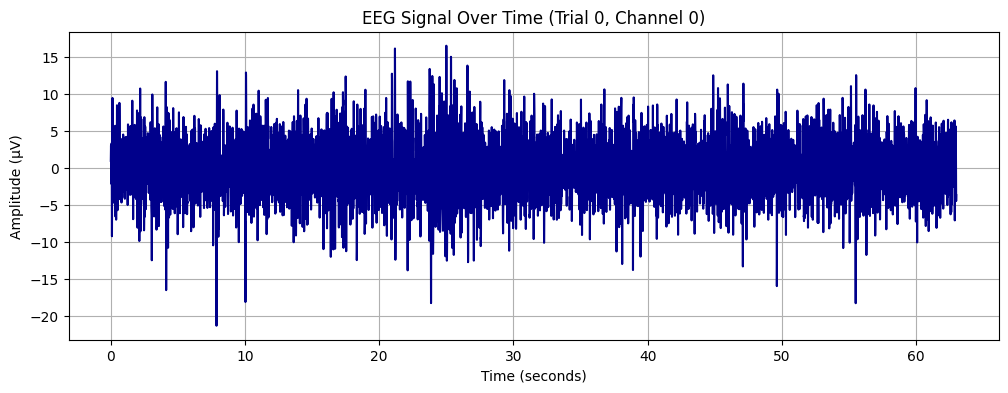

/tmp/ipython-input-3557127149.py:29: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 128, using nperseg = 128
  f, Pxx = welch(segment, fs=128)


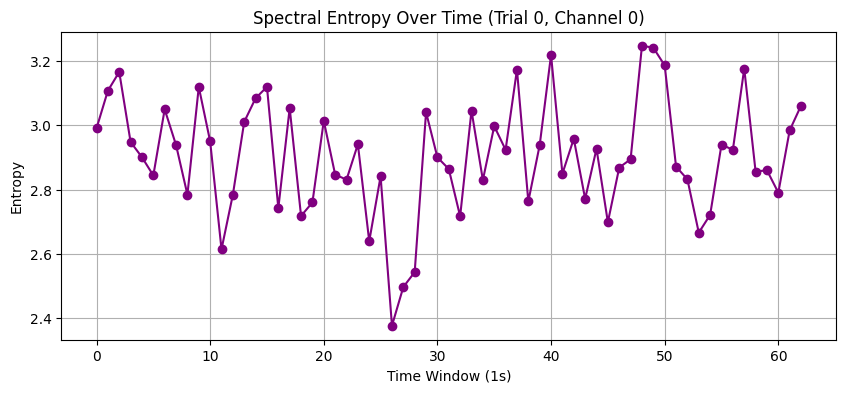

In [27]:
## 4. Temporal Analysis: Arousal Over Time in a Trial
import matplotlib.pyplot as plt

# Select one trial and one EEG channel
trial_index = 0
channel_index = 0
signal = eeg_data_all[trial_index][channel_index]  # shape: (8064,)
time = np.linspace(0, len(signal)/128, len(signal))  # 128 Hz sampling rate

# Plot full signal
plt.figure(figsize=(12, 4))
plt.plot(time, signal, color='darkblue')
plt.title("EEG Signal Over Time (Trial 0, Channel 0)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()

# Optional: segment signal into 1-second windows and compute entropy over time
from scipy.signal import welch
from scipy.stats import entropy

window_size = 128  # 1 second
entropy_over_time = []

for i in range(0, len(signal), window_size):
    segment = signal[i:i+window_size]
    if len(segment) == window_size:
        f, Pxx = welch(segment, fs=128)
        Pxx_norm = Pxx / np.sum(Pxx)
        entropy_over_time.append(entropy(Pxx_norm))

# Plot entropy over time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(entropy_over_time)), entropy_over_time, marker='o', color='purple')
plt.title("Spectral Entropy Over Time (Trial 0, Channel 0)")
plt.xlabel("Time Window (1s)")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()

**result:** performing a temporal analysis of the EEG signal for a single trial and channel, plotting the raw signal over time and the spectral entropy over time in 1-second windows. The plots visualize the signal and how its complexity (as measured by entropy) changes during the trial.


In [30]:
## Part 5: Subject-Specific vs Subject-Independent Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Choose one subject (e.g., subject 0)
subject_id = 0
start = subject_id * 40
end = (subject_id + 1) * 40

# Subject-specific data
X_sub = np.array([extract_features_with_entropy(trial) for trial in eeg_data_all[start:end]])
y_sub = np.array([bin_arousal_3class(r) for r in arousal_labels[start:end]])

# Train/test split for subject-specific
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
model_sub = RandomForestClassifier(random_state=42)
model_sub.fit(X_train_sub, y_train_sub)
y_pred_sub = model_sub.predict(X_test_sub)
f1_sub = f1_score(y_test_sub, y_pred_sub, average='macro')
print(" Subject-Specific F1 Score:", f1_sub)

# Subject-independent: train on all other subjects
X_all = np.array([extract_features_with_entropy(trial) for trial in eeg_data_all])
y_all = np.array([bin_arousal_3class(r) for r in arousal_labels])

X_train_ind = np.delete(X_all, slice(start, end), axis=0)
y_train_ind = np.delete(y_all, slice(start, end), axis=0)
X_test_ind = X_all[start:end]
y_test_ind = y_all[start:end]

model_ind = RandomForestClassifier(random_state=42)
model_ind.fit(X_train_ind, y_train_ind)
y_pred_ind = model_ind.predict(X_test_ind)
f1_ind = f1_score(y_test_ind, y_pred_ind, average='macro')
print(" Subject-Independent F1 Score:", f1_ind)


print("\n Subject-Independent Model Performance:")
print("Accuracy:", accuracy_score(y_test_ind, y_pred_ind))
print("Precision:", precision_score(y_test_ind, y_pred_ind, average='macro'))
print("Recall:", recall_score(y_test_ind, y_pred_ind, average='macro'))
print("F1 Score:", f1_score(y_test_ind, y_pred_ind, average='macro'))

 Subject-Specific F1 Score: 0.20833333333333334
 Subject-Independent F1 Score: 0.12244897959183675

 Subject-Independent Model Performance:
Accuracy: 0.225
Precision: 0.075
Recall: 0.3333333333333333
F1 Score: 0.12244897959183675


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**result:** subject-specific and subject-independent modeling approaches have been compared using a RandomForest classifier for the 3-class arousal classification. It trained a model on a single subject's data and evaluated it on that subject's test data, and trained another model on data from all other subjects and evaluated it on the held-out subject's data. The results show that the subject-specific model achieved a higher F1-score (0.208) compared to the subject-independent model (0.122) for the chosen subject, suggesting that individual differences in EEG signals might be significant.